Install required packages

In [1]:
cd '/content/'

%%bash

# Install BARTs dependencies

apt-get install -y make gcc libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev &> /dev/null

# Download BART version

[ -d /content/bart ] && rm -r /content/bart
git clone https://github.com/mrirecon/bart/ bart

[ -d "bart" ] && echo "BART branch ${BRANCH} was downloaded successfully."

cd bart

# Switch to desired branch of the BART project
BRANCH="master"
git checkout $BRANCH

# Define specifications 
COMPILE_SPECS=" PARALLEL=4
                CUDA=1
                CUDA_BASE=/usr/local/cuda
                CUDA_LIB=lib64"

printf "%s\n" $COMPILE_SPECS > Makefiles/Makefile.local

# Compile BART with CUDA
make &> /dev/null

cd ..


BART branch  was downloaded successfully.
Your branch is up to date with 'origin/master'.


Cloning into 'bart'...
Already on 'master'


In [28]:
import os
import sys

# Define environment variables for BART and OpenMP

os.environ['TOOLBOX_PATH'] = "/content/bart"

os.environ['OMP_NUM_THREADS']="4"

# Add the BARTs toolbox to the PATH variable

os.environ['PATH'] = os.environ['TOOLBOX_PATH'] + ":" + os.environ['PATH']
sys.path.append(os.environ['TOOLBOX_PATH'] + "/python")

In [29]:
!bart

BART. Available commands are:
avg         bench       bin         bitmask     cabs        caldir      
calmat      carg        casorati    cc          ccapply     cdf97       
circshift   conj        conv        conway      copy        cpyphs      
creal       crop        delta       ecalib      ecaltwo     epg         
estdelay    estdims     estshift    estvar      extract     fakeksp     
fft         fftmod      fftrot      fftshift    filter      flatten     
flip        fmac        fovshift    homodyne    index       invert      
itsense     join        looklocker  lrmatrix    mandelbrot  measure     
mip         moba        mobafit     multicfl    nlinv       nnet        
noise       normalize   nrmse       nufft       onehotenc   ones        
pattern     phantom     pics        pocsense    poisson     pol2mask    
poly        reconet     repmat      reshape     resize      rmfreq      
rof         roistat     rss         rtnlinv     sake        saxpy       
scale       sdot     

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/fastMRI/X-MRI/fastMRI 
!pip install -e .

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/fastMRI/X-MRI/fastMRI
Obtaining file:///content/drive/MyDrive/fastMRI/X-MRI/fastMRI
  Attempting uninstall: fastmri
    Found existing installation: fastmri 0.1.2a20210917b
    Can't uninstall 'fastmri'. No files were found to uninstall.
  Running setup.py develop for fastmri


Train with SSL

In [2]:
%matplotlib inline

import sys
sys.path.insert(0,'/content/drive/MyDrive/fastMRI/X-MRI/fastMRI')
import fastmri
import h5py
import numpy as np
from matplotlib import pyplot as plt

import numpy as np
import torch
from fastmri.data import transforms as fastmri_transforms
from fastmri.data.subsample import MaskFunc
from typing import Dict, Optional, Tuple
from fastmri.data import subsample
%cd /content/drive/MyDrive/fastMRI/X-MRI/fastMRI/fastmri_examples/self_supervised




/content/drive/MyDrive/fastMRI/X-MRI/fastMRI/fastmri_examples/self_supervised


In [ ]:
%cd /content/drive/MyDrive/fastMRI/X-MRI/fastMRI/fastmri_examples/self_supervised
!python3 run_self_supervised_kspace_2.py \
    --data_path "/content/drive/MyDrive/fastMRI/X-MRI/truncated" \
    --checkpoint_path "/content/drive/MyDrive/fastMRI/X-MRI/ouputs/ssl_output_cs2" \
    --device cuda

/content/drive/MyDrive/fastMRI/X-MRI/fastMRI/fastmri_examples/self_supervised
Global seed set to 42
-----------------------------------
Epoch 1
-----------------------------------
  0% 0/724 [00:00<?, ?it/s]torch.Size([2, 320, 320, 2])
Done.
Done.
Batch: 1, Loss: 2.8329854:   0% 1/724 [00:03<37:29,  3.11s/it]torch.Size([2, 320, 320, 2])
Done.
Done.
Batch: 2, Loss: 2.7032676:   0% 2/724 [00:05<34:50,  2.90s/it]torch.Size([2, 320, 320, 2])
Done.
Done.
Batch: 3, Loss: 2.8834307:   0% 3/724 [00:08<33:52,  2.82s/it]torch.Size([2, 320, 320, 2])
Done.
Done.
Batch: 4, Loss: 2.8307602:   1% 4/724 [00:11<33:23,  2.78s/it]torch.Size([2, 320, 320, 2])
Done.
Done.
Batch: 5, Loss: 2.5585256:   1% 5/724 [00:14<32:57,  2.75s/it]torch.Size([2, 320, 320, 2])
Done.
Done.
Batch: 6, Loss: 2.6489820:   1% 6/724 [00:16<32:45,  2.74s/it]torch.Size([2, 320, 320, 2])
Done.
Done.
Batch: 7, Loss: 2.3870516:   1% 7/724 [00:19<32:30,  2.72s/it]torch.Size([2, 320, 320, 2])
Done.
Done.
Batch: 8, Loss: 2.5619898:   1%

In [3]:
file_name = '/content/drive/MyDrive/fastMRI/X-MRI/singlecoil_train/file1000200.h5'
hf = h5py.File(file_name)

In [4]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(37, 640, 372)


In [5]:
from pathlib import Path
def get_sorted_checkpoint_files(checkpoint_dir: Path):
    files = list(checkpoint_dir.glob('*.pt'))
    files.sort()
    return files

In [6]:
def choose_loss_split(volume, ratio=0.5):
    # TODO: come back and implement overlap
    # volume format: (image, target, mean, std, fname, slice_num, max_value)
    print(volume.shape)
    
    arange = np.arange(volume.shape[0])
    rng = np.random.default_rng() # corrected the random generator
    theta_indices = rng.choice(arange, size=int(volume.shape[0] * ratio), replace=False)
    lambda_indices = arange[np.isin(arange, theta_indices, invert=True)]
    volume_theta_view = volume[theta_indices].unsqueeze(1) # added unsqueeze
    volume_lambda_view = volume[lambda_indices].unsqueeze(1) # added unsqueeze
    return volume_theta_view, volume_lambda_view


torch.Size([320, 320, 2])
torch.Size([1, 2, 320, 320])
Layer (type:depth-idx)                   Output Shape              Param #
MriSelfSupervised                        --                        --
├─ModuleList: 1-1                        --                        --
├─ReLU: 1-2                              [1, 2, 320, 320]          --
├─Conv2d: 1-3                            [1, 64, 320, 320]         1,216
├─ReLU: 1-4                              [1, 64, 320, 320]         --
├─ModuleList: 1-1                        --                        --
│    └─ResidualBlock: 2-1                [1, 64, 320, 320]         --
│    │    └─Conv2d: 3-1                  [1, 64, 320, 320]         36,928
│    │    └─BatchNorm2d: 3-2             [1, 64, 320, 320]         128
│    │    └─ReLU: 3-3                    [1, 64, 320, 320]         --
│    │    └─Conv2d: 3-4                  [1, 64, 320, 320]         36,928
│    │    └─BatchNorm2d: 3-5             [1, 64, 320, 320]         128
│    │    └─ReLU:

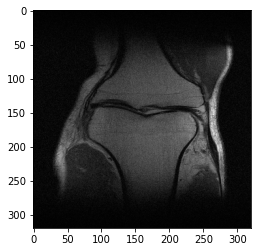

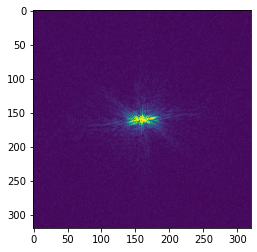

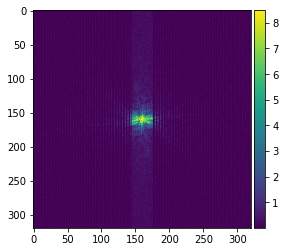

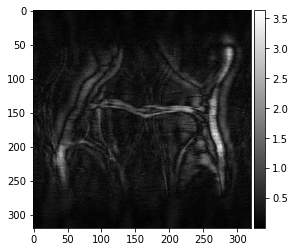

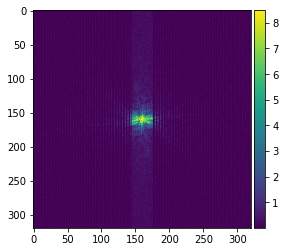

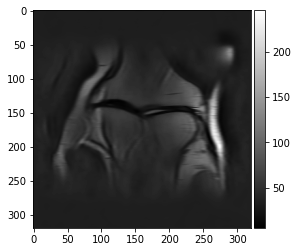

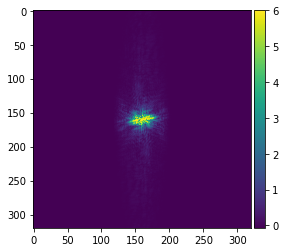

In [27]:
from ssl_transform_kspace import SslTransform
from self_supervised import MriSelfSupervised
%pip install torchinfo
from torchinfo import summary


from mpl_toolkits.axes_grid1 import make_axes_locatable

slice_kspace = volume_kspace[20] # Choosing the 20-th slice of this volume
slice_kspace = fastmri_transforms.to_tensor(slice_kspace)

mask = subsample.create_mask_for_mask_type('equispaced',[0.08],[4])
masked_kspace = fastmri_transforms.apply_mask(slice_kspace, mask)[0]

fig1, ax = plt.subplots()
ax.imshow(fastmri.complex_abs(fastmri.ifft2c(fastmri_transforms.complex_center_crop(slice_kspace, [320, 320]))), cmap='gray')
#ax[1].imshow(np.log(fastmri.complex_abs(masked_kspace)))

img_und_cropped = fastmri_transforms.complex_center_crop(masked_kspace, [320, 320])
img_cropped = fastmri_transforms.complex_center_crop(slice_kspace, [320, 320])
original = img_cropped
undersampled = img_und_cropped
#img_und_cropped = fastmri.complex_abs(img_und_cropped)
img_cropped = fastmri.complex_abs(img_cropped)

img_und_cropped, mean, std = fastmri_transforms.normalize_instance(img_und_cropped, eps=1e-11)
img_und_cropped = img_und_cropped.clamp(-6, 6)

img_cropped, mean, std = fastmri_transforms.normalize_instance(img_cropped, eps=1e-11)
img_cropped = img_cropped.clamp(-6, 6)




fig2, ax = plt.subplots()
ax.imshow(img_cropped)

fig3, ax = plt.subplots()
im=ax.imshow(fastmri.complex_abs(img_und_cropped))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig3.colorbar(im,cax=cax)



checkpoint_dir = Path("/content/drive/MyDrive/fastMRI/X-MRI/ouputs/ssl_output_2")
files = get_sorted_checkpoint_files(checkpoint_dir)
checkpoint = torch.load(files[-1])

img_und_cropped = fastmri.ifft2c(img_und_cropped)
baseline_kspace = fastmri.fft2c(img_und_cropped)

fig7, ax = plt.subplots()
im=ax.imshow(fastmri.complex_abs(img_und_cropped), cmap='gray')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig7.colorbar(im,cax=cax)

fig99, ax = plt.subplots()
im=ax.imshow(fastmri.complex_abs(baseline_kspace))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig99.colorbar(im,cax=cax)

print(img_und_cropped.shape)
img_und_cropped =img_und_cropped.unsqueeze(0).permute(0,3,1,2)

model = []
model = MriSelfSupervised()
model.load_state_dict(checkpoint['model_state_dict'])

print(img_und_cropped.shape)

#img_und_cropped_inmodel = img_und_cropped.unsqueeze(0).unsqueeze(0)
#img_und_normalised = img_und_padded * norm.to(device, dtype=torch.float) 
pred = model(img_und_cropped)
print(summary(model,(1, 2, 320, 320)))

#pred, mean, std = fastmri_transforms.normalize_instance(pred, eps=1e-11)
#pred = pred.clamp(-6, 6)

pred = pred.permute(0,2,3,1)
output = fastmri.complex_abs(pred).squeeze(0)
pred = fastmri.fft2c(pred)
pred = fastmri.complex_abs(pred).squeeze(0)

pred, mean, std = fastmri_transforms.normalize_instance(pred, eps=1e-11)
pred = pred.clamp(-6, 6)


fig7, ax = plt.subplots()
im=ax.imshow(output.detach(), cmap='gray')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig7.colorbar(im, cax=cax)

fig8, ax = plt.subplots()
im=ax.imshow(pred.detach().detach())
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig8.colorbar(im, cax=cax)


Use compressed sensing as initiation

tensor(1.3631, device='cuda:0', requires_grad=True)
torch.Size([320, 320, 2])
<bound method Module.parameters of MriSelfSupervised(
  (mri_relu): ReLU(inplace=True)
  (mri_conv1): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mri_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (residual_blocks): ModuleList(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(in

/usr/local/lib/python3.7/dist-packages/skimage/metrics/_structural_similarity.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  im2 = im2.astype(np.float64)


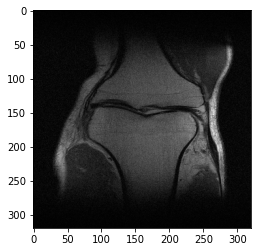

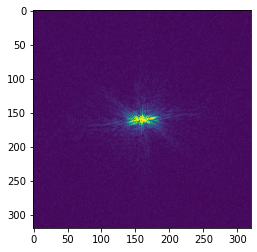

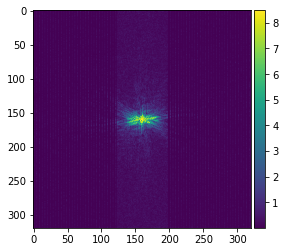

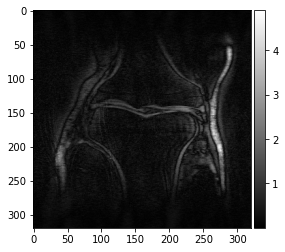

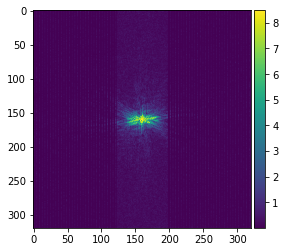

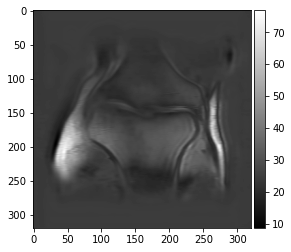

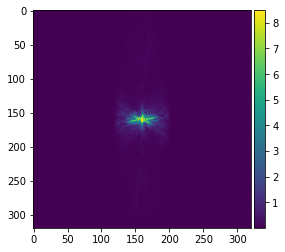

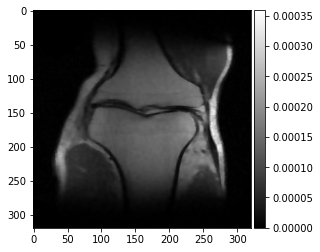

In [36]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from bart import bart
from self_supervised_2 import MriSelfSupervised
from torchsummary import summary

slice_kspace = volume_kspace[20] # Choosing the 20-th slice of this volume
slice_kspace = fastmri_transforms.to_tensor(slice_kspace)

mask = subsample.create_mask_for_mask_type('equispaced',[0.2],[4])
masked_kspace = fastmri_transforms.apply_mask(slice_kspace, mask)[0]

fig1, ax = plt.subplots()
ax.imshow(fastmri.complex_abs(fastmri.ifft2c(fastmri_transforms.complex_center_crop(slice_kspace, [320, 320]))), cmap='gray')
#ax[1].imshow(np.log(fastmri.complex_abs(masked_kspace)))

img_und_cropped = fastmri_transforms.complex_center_crop(masked_kspace, [320, 320])
img_cropped = fastmri_transforms.complex_center_crop(slice_kspace, [320, 320])
original = img_cropped
undersampled = img_und_cropped
#img_und_cropped = fastmri.complex_abs(img_und_cropped)
img_cropped = fastmri.complex_abs(img_cropped)

img_und_cropped, mean, std = fastmri_transforms.normalize_instance(img_und_cropped, eps=1e-11)
img_und_cropped = img_und_cropped.clamp(-6, 6)

img_cropped, mean, std = fastmri_transforms.normalize_instance(img_cropped, eps=1e-11)
img_cropped = img_cropped.clamp(-6, 6)




fig2, ax = plt.subplots()
ax.imshow(img_cropped)

fig3, ax = plt.subplots()
im=ax.imshow(fastmri.complex_abs(img_und_cropped))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig3.colorbar(im,cax=cax)



checkpoint_dir = Path("/content/drive/MyDrive/fastMRI/X-MRI/ouputs/ssl_output_cs")
files = get_sorted_checkpoint_files(checkpoint_dir)
checkpoint = torch.load(files[-1])
loss = checkpoint['loss']
print(loss)


img_und_cropped = fastmri.ifft2c(img_und_cropped)
baseline_kspace = fastmri.fft2c(img_und_cropped)

fig7, ax = plt.subplots()
im=ax.imshow(fastmri.complex_abs(img_und_cropped), cmap='gray')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig7.colorbar(im,cax=cax)

fig99, ax = plt.subplots()
im=ax.imshow(fastmri.complex_abs(baseline_kspace))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig99.colorbar(im,cax=cax)

print(img_und_cropped.shape)
#img_und_cropped =img_und_cropped.unsqueeze(0).permute(0,3,1,2)

model = []
model = MriSelfSupervised()
print(model.parameters)
#print(summary(model,(2,320,320)))
model.load_state_dict(checkpoint['model_state_dict'])



#img_und_cropped_inmodel = img_und_cropped.unsqueeze(0).unsqueeze(0)
#img_und_normalised = img_und_padded * norm.to(device, dtype=torch.float) 
kspace_bart = fastmri.tensor_to_complex_np(undersampled)
sens = bart(1, 'ecalib -d0 -m1', kspace_bart).squeeze()
pred = bart(1, f"pics -d0 -S -R T:7:0:0.1 -i 10", kspace_bart, sens)
bart_pred = pred



v_bart = fastmri_transforms.to_tensor(pred)
v_bart, mean, std = fastmri_transforms.normalize_instance(v_bart, eps=1e-11)
v_bart = v_bart.unsqueeze(0).permute(0,3,1,2)
print(pred.shape)
v_ifft = fastmri.ifft2c(undersampled).unsqueeze(0)
v_ifft, mean, std = fastmri_transforms.normalize_instance(v_ifft, eps=1e-11)
v_ifft = v_ifft.permute(0,3,1,2)
print(v_ifft.shape)
v = torch.cat((v_ifft, v_bart),1)
pred = model(v)

#pred, mean, std = fastmri_transforms.normalize_instance(pred, eps=1e-11)
#pred = pred.clamp(-6, 6)

pred = pred.permute(0,2,3,1)
output, mean, std = fastmri_transforms.normalize_instance(pred, eps=1e-11)
output = output.clamp(-6, 6)
output = fastmri.complex_abs(pred).squeeze(0)
#output, mean, std = fastmri_transforms.normalize_instance(output, eps=1e-11)
pred = fastmri.fft2c(pred)
#pred = fastmri.complex_abs(pred).squeeze(0)

pred, mean, std = fastmri_transforms.normalize_instance(pred, eps=1e-11)
pred = pred.clamp(-6, 6)

pred = fastmri.complex_abs(pred.squeeze(0))


fig7, ax = plt.subplots()
im=ax.imshow(output.detach(), cmap='gray')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig7.colorbar(im, cax=cax)

fig8, ax = plt.subplots()
im=ax.imshow(pred.detach().detach())
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig8.colorbar(im, cax=cax)

fig9, ax = plt.subplots()
im=ax.imshow(np.abs(bart_pred),cmap='gray')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig8.colorbar(im, cax=cax)

from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
print(img_und_cropped.shape)

ssim_und = ssim(img_cropped.numpy(), fastmri.complex_abs(img_und_cropped).numpy(),
                data_range=img_cropped.numpy().max() - img_cropped.numpy().min())
print(np.abs(ssim_und))

ssim_output = ssim(img_cropped.numpy(), output.detach().numpy(),
                   data_range=img_cropped.numpy().max() - img_cropped.numpy().min())
print(np.abs(ssim_output))

ssim_bart = ssim(img_cropped.numpy(), bart_pred,
                 data_range=img_cropped.numpy().max() - img_cropped.numpy().min())
print(ssim_bart)



In [ ]:
%cd /content/drive/MyDrive/fastMRI/X-MRI/fastMRI/fastmri_examples/cs/
!python run_bart.py \
    --challenge singlecoil \
    --data_path "/content/drive/MyDrive/fastMRI/X-MRI/truncated" \
    --output_path "/content/drive/MyDrive/fastMRI/X-MRI/ouputs/cs_recon" \
    --reg_wt 0.01 \
    --mask_type random \
    --split val

/content/drive/MyDrive/fastMRI/X-MRI/fastMRI/fastmri_examples/cs
Traceback (most recent call last):
  File "run_bart.py", line 15, in <module>
    from bart import bart
ModuleNotFoundError: No module named 'bart'


(320, 320)
torch.Size([320, 320, 2])
(320, 320)


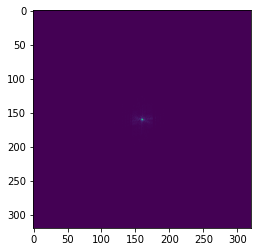

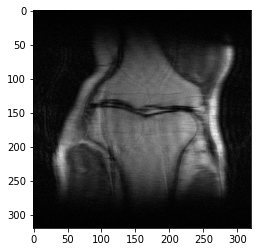

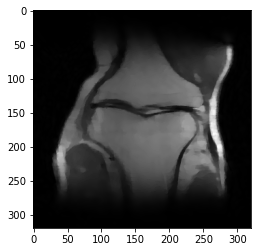

In [ ]:
from bart import bart
print(img_und_cropped.shape)
kspace = undersampled
base = fastmri.ifft2c(kspace)
print(kspace.shape)

kspace = fastmri.tensor_to_complex_np(kspace)


print(kspace.shape)

figure=plt
plt.imshow(np.abs(kspace))

sens = bart(1, 'ecalib -m1', kspace).squeeze()
pred = bart(1, f"pics -d0 -S -R T:7:0:0.1 -i 50", kspace, sens)

figure1, ax1=plt.subplots()
im1=ax1.imshow(fastmri.complex_abs(base),cmap='gray')

figure2,ax2=plt.subplots()
im2=ax2.imshow(np.abs(pred),cmap='gray')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


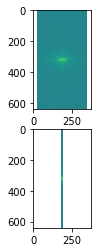

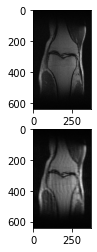

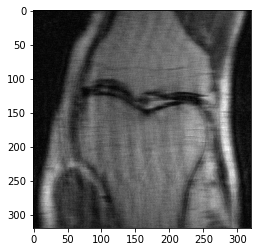

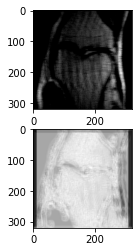

In [ ]:
slice_kspace = volume_kspace[20] # Choosing the 20-th slice of this volume
slice_kspace = fastmri_transforms.to_tensor(slice_kspace)

mask = subsample.create_mask_for_mask_type('random',[0.08],[4])
masked_kspace = fastmri_transforms.apply_mask(slice_kspace, mask)[0]

fig1, ax = plt.subplots(2)
ax[0].imshow(np.log(fastmri.complex_abs(slice_kspace)))
ax[1].imshow(np.log(fastmri.complex_abs(masked_kspace)))



img_full = fastmri.ifft2c(slice_kspace)
img_und = fastmri.ifft2c(masked_kspace)

fig2, ax = plt.subplots(2)
ax[0].imshow(fastmri.complex_abs(img_full), cmap='gray')
ax[1].imshow(fastmri.complex_abs(img_und), cmap='gray')

img_und_cropped = fastmri_transforms.complex_center_crop(img_und, [320, 320])
img_und_cropped = fastmri.complex_abs(img_und_cropped)

img_und_cropped, mean, std = fastmri_transforms.normalize_instance(img_und_cropped, eps=1e-11)
img_und_cropped = img_und_cropped.clamp(-6, 6)

fig3, ax = plt.subplots()
ax.imshow(img_und_cropped, cmap='gray')

checkpoint_dir = Path("/content/drive/MyDrive/fastMRI/X-MRI/ouputs/ssl_output/checkpoint")
files = get_sorted_checkpoint_files(checkpoint_dir)
checkpoint = torch.load(files[-1])

model = MriSelfSupervised()
model.load_state_dict(checkpoint['model_state_dict'])

img_und_cropped_inmodel = img_und_cropped.unsqueeze(0).unsqueeze(0)
#img_und_normalised = img_und_padded * norm.to(device, dtype=torch.float) 
pred = model(img_und_cropped_inmodel)
pred = pred.clamp(-6, 6)
pred = pred.squeeze(0).squeeze(0).detach().numpy()

pred, mean, std = fastmri_transforms.normalize_instance(pred, eps=1e-11)



fig3, ax = plt.subplots(2)
ax[0].imshow(img_und_cropped, cmap='gray')
ax[1].imshow(pred, cmap='gray')



torch.Size([320, 320])
torch.Size([160, 1, 320])


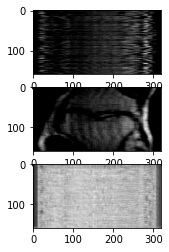

In [ ]:
volume_theta_view, volume_lambda_view= choose_loss_split(img_und_cropped, ratio=0.5)
print(volume_theta_view.shape)
volume_theta_view = volume_theta_view.squeeze(1)
volume_lambda_view=  volume_lambda_view.squeeze(1)
pred = model(volume_theta_view.unsqueeze(0).unsqueeze(0))

fig4, ax = plt.subplots(3)
ax[0].imshow(volume_theta_view.cpu(), cmap='gray')
ax[1].imshow(volume_lambda_view.cpu(), cmap='gray')
ax[2].imshow(pred.squeeze(0).squeeze(0).detach().numpy(), cmap='gray')


TypeError: ignored

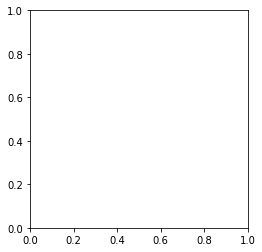

In [ ]:
show_coils(np.log(np.abs(slice_kspace) + 1e-9), [0])  # This shows coils 0, 5 and 10

In [ ]:
import fastmri
from fastmri.data import transforms as T

In [ ]:
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

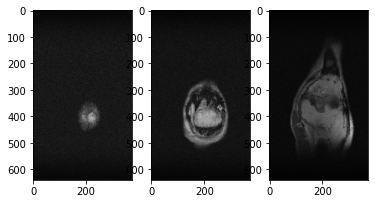

In [ ]:
show_coils(slice_image_abs, [0, 5, 10], cmap='gray')

In [ ]:
from fastmri.data.subsample import RandomMaskFunc
mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object

In [ ]:
masked_kspace = T.apply_mask(slice_kspace2, mask_func)[0]   # Apply the mask to k-space

In [ ]:
sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)